<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model.
5. Assess expected accuracy and tune your models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

In [1]:
import pandas as pd
# Training dataset
data=pd.read_csv('mimic_train.csv')
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [2]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('mimic_test_death.csv')
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [3]:
# Your code here

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
import scipy

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score, confusion_matrix
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import category_encoders as encoders

random.seed(5541)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


metadata = pd.read_csv('MIMIC_metadata_diagnose.csv')
diagnoses_file = pd.read_csv('MIMIC_diagnoses.csv')


# Step 1: Combine metadata and diagnose_file based on 'ICD9_CODE'
merged_intermediate = metadata.merge(diagnoses_file, on='ICD9_CODE', how='inner')
merged_intermediate.rename(columns={'HADM_ID': 'hadm_id'}, inplace=True)
merged_intermediate.rename(columns={'SUBJECT_ID': 'subject_id'}, inplace=True)
merged_intermediate = merged_intermediate[merged_intermediate['SEQ_NUM'] == 3] #drop seq_numbers not equal to 2
merged_intermediate.rename(columns={'ICD9_CODE': 'ICD9_CODE_seq_3'}, inplace=True)

# Step 2: Combine the intermediate dataset with X_train and X_test based on 'ID'
data = data.merge(merged_intermediate[['hadm_id', 'ICD9_CODE_seq_3']], on=['hadm_id'], how='left')
data_test = data_test.merge(merged_intermediate[['hadm_id', 'ICD9_CODE_seq_3']], on=['hadm_id'], how='left')
###########################################################
metadata = pd.read_csv('MIMIC_metadata_diagnose.csv')
diagnoses_file = pd.read_csv('MIMIC_diagnoses.csv')


# Step 1: Combine metadata and diagnose_file based on 'ICD9_CODE'
merged_intermediate = metadata.merge(diagnoses_file, on='ICD9_CODE', how='inner')
merged_intermediate.rename(columns={'HADM_ID': 'hadm_id'}, inplace=True)
merged_intermediate.rename(columns={'SUBJECT_ID': 'subject_id'}, inplace=True)
merged_intermediate = merged_intermediate[merged_intermediate['SEQ_NUM'] == 4] #drop seq_numbers not equal to 2
merged_intermediate.rename(columns={'ICD9_CODE': 'ICD9_CODE_seq_4'}, inplace=True)

# Step 2: Combine the intermediate dataset with X_train and X_test based on 'ID'
data = data.merge(merged_intermediate[['hadm_id', 'ICD9_CODE_seq_4']], on=['hadm_id'], how='left')
data_test = data_test.merge(merged_intermediate[['hadm_id', 'ICD9_CODE_seq_4']], on=['hadm_id'], how='left')


In [5]:
#Use metadata diagnosis apart from 1:
metadata = pd.read_csv('MIMIC_metadata_diagnose.csv').copy()
diagnoses = pd.read_csv('MIMIC_diagnoses.csv').copy()

def process_data(seq_num, data, data_test):

    # Combine metadata and diagnoses_file based on 'ICD9_CODE'
    merged_intermediate = metadata.merge(diagnoses, on='ICD9_CODE', how='inner')
    merged_intermediate.rename(columns={'HADM_ID': 'hadm_id', 'SUBJECT_ID': 'subject_id'}, inplace=True)
    merged_intermediate = merged_intermediate[merged_intermediate['SEQ_NUM'] == seq_num]

    # Rename the 'ICD9_CODE' column in the merged result
    column_name = f'ICD9_CODE_seq_{seq_num}'
    merged_intermediate.rename(columns={'ICD9_CODE': column_name}, inplace=True)
    # Combine the intermediate dataset with X_train and X_test based on 'ID'
    data = data.merge(merged_intermediate[['hadm_id', column_name]], on=['hadm_id'], how='left')
    data_test = data_test.merge(merged_intermediate[['hadm_id', column_name]], on=['hadm_id'], how='left')

    return data, data_test

# Process data for SEQ_NUM = 2
data, data_test = process_data(2, data, data_test)

# Process data for SEQ_NUM = 3
data, data_test = process_data(3, data, data_test)

# Process data for SEQ_NUM = 4
data, data_test = process_data(4, data, data_test)

#If someone does'n have any extra diagnose apart from 1, fill these na values with no_diagnose

columns_to_process = ['ICD9_CODE_seq_2', 'ICD9_CODE_seq_3', 'ICD9_CODE_seq_4']

# Process NaN values 
for column_name in columns_to_process:
    # Replace NaN values in each column with 'other'
    data[column_name].fillna('no_diagnose', inplace=True)
    data_test[column_name].fillna('no_diagnose', inplace=True)

# Step 1: Count occurrences of 'id' in df2 for each individual
count_diagnoses = diagnoses.groupby('HADM_ID').size().reset_index()

count_diagnoses.columns = ['HADM_ID', 'id_count']
count_diagnoses.rename(columns={'HADM_ID': 'hadm_id'}, inplace=True)

# Step 3: Merge count_df2 with df1 based on 'individual_id'
data = data.merge(count_diagnoses, on='hadm_id', how='left')
data_test = data_test.merge(count_diagnoses, on='hadm_id', how='left')

In [6]:
#create X and y test and y train

y_train = data['HOSPITAL_EXPIRE_FLAG']
X_train = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1) 
X_test = data_test.copy()

In [7]:
#dates transformation
from datetime import datetime, timedelta

# Define a function get the diffrence in days bewteen two dates:
def date_difference(date_str):
    date_obj1 = datetime.strptime(date_str['DOB'], '%Y-%m-%d %H:%M:%S')
    date_obj2 = datetime.strptime(date_str['ADMITTIME'], '%Y-%m-%d %H:%M:%S')
    delta = date_obj2 - date_obj1
    return (delta.days) /365

X_train['age'] = X_train.apply(date_difference, axis=1)
X_test['age'] = X_test.apply(date_difference, axis=1)
# Clip the 'age' values to a maximum of 100
X_train['age'] = X_train['age'].apply(lambda x: np.clip(x, None, 90))
X_test['age'] = X_test['age'].apply(lambda x: np.clip(x, None, 90))
print(X_train['age'])

print(X_train)


0        69.608219
1        42.101370
2        68.210959
3        74.961644
4        79.424658
           ...    
20880    87.561644
20881    65.901370
20882    62.931507
20883    90.000000
20884    45.775342
Name: age, Length: 20885, dtype: float64
       subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
0           55440   195768      228357           89.0          145.0   
1           76908   126136      221004           63.0          110.0   
2           95798   136645      296315           81.0           98.0   
3           40708   102505      245557           76.0          128.0   
4           28424   127337      225281            NaN            NaN   
...           ...      ...         ...            ...            ...   
20880       28043   135417      244530           65.0           92.0   
20881       87605   191007      216116           74.0          112.0   
20882       47492   152608      274507           58.0           97.0   
20883       62946   191485    

from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import feature_importances
cnames_numeric=list(X_train.select_dtypes(exclude =['object']).columns)
cnames_numeric

feature_importances(DecisionTreeClassifier(), data[cnames_numeric], y_train.astype(int))

In [8]:
#drop id variables and categorical variables
list_drop_train = ['subject_id','hadm_id','icustay_id','DOD','ADMITTIME', 'DISCHTIME', 'DEATHTIME'
                        , 'LOS', 'Diff', 'DOB']

list_drop_test = ['subject_id','hadm_id','icustay_id','ADMITTIME'
                        , 'Diff', 'DOB']
X_train = X_train.drop(list_drop_train, axis=1)
X_test = X_test.drop(list_drop_test, axis=1)

#Get column names of vategorical and numeric variables
#cnames_numeric=list(X_train.select_dtypes(exclude=['object']).columns)

#lists of numeric and categorical columns
cnames_categorical=list(X_train.select_dtypes(include =['object']).columns)
print(cnames_categorical)

cnames_numeric=list(X_train.select_dtypes(exclude =['object']).columns)
print(cnames_numeric)

['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'ICD9_CODE_seq_2', 'ICD9_CODE_seq_3', 'ICD9_CODE_seq_4']
['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'age']


In [9]:
#create list with columns to be used later on:
categorical_cols_target = cnames_categorical.copy()
categorical_cols_count = cnames_categorical.copy()

categorical_cols_count = ['MARITAL_STATUS', 'GENDER', 'ADMISSION_TYPE', 'ETHNICITY', 'FIRST_CAREUNIT', 'INSURANCE',  'RELIGION']
categorical_cols_target = ['DIAGNOSIS', 'ICD9_CODE_seq_2','ICD9_diagnosis', 'ICD9_CODE_seq_3', 'ICD9_CODE_seq_4']

for var in ['ICD9_diagnosis', 'DIAGNOSIS']:
    # Calculate the frequency of each category in the column
    category_counts_train = X_train[var].value_counts()
    category_counts_test = X_test[var].value_counts()
    # Calculate the threshold for "other" based on 5% of the total count
    threshold_train = 0.01 * len(X_train)
    threshold_test = 0.01 * len(X_test)
    # Identify categories that appear less than the threshold
    infrequent_categories_train = category_counts_train[category_counts_train < threshold_train].index
    infrequent_categories_test = category_counts_test[category_counts_test < threshold_test].index
    # Replace infrequent categories with 'other'
    X_train[var] = X_train[var].apply(lambda x: 'other' if x in infrequent_categories_train else x)
    X_test[var] = X_test[var].apply(lambda x: 'other' if x in infrequent_categories_test else x)

MOST FREQUENT IMPUTER

# Create a subset of X_train and X_test with the specified columns
X_train_subset = X_train[categorical_cols_count]
X_test_subset = X_test[categorical_cols_count]

#Impute categorical variables (by mode)

imp_frequent = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imp_frequent.fit(X_train_subset) #use train mode!

X_train_subset = pd.DataFrame(imp_frequent.transform(X_train_subset), columns = categorical_cols_count)
X_test_subset = pd.DataFrame(imp_frequent.transform(X_test_subset), columns = categorical_cols_count)

# Update the original DataFrames with the imputed values
X_train[categorical_cols_count] = X_train_subset
X_test[categorical_cols_count] = X_test_subset

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

### Combine Sparse Classes

When dealing with categories, you might test the frequency of certain classes, and group the less frequent classes, but making sure that their behavior is similar with respect to the target to predict.

Think that you are estimating some effect for each extra variable you add, so do you really want to estimate a effect based on on or two observations

for var in ['ETHNICITY', 'RELIGION', 'MARITAL_STATUS']:
    # Calculate the frequency of each category in the column
    category_counts_train = X_train[var].value_counts()
    category_counts_test = X_test[var].value_counts()
    # Calculate the threshold for "other" based on 5% of the total count
    threshold_train = 0.05 * len(X_train)
    threshold_test = 0.05 * len(X_test)
    # Identify categories that appear less than the threshold
    infrequent_categories_train = category_counts_train[category_counts_train < threshold_train].index
    infrequent_categories_test = category_counts_test[category_counts_test < threshold_test].index
    # Replace infrequent categories with 'other'
    X_train[var] = X_train[var].apply(lambda x: 'other' if x in infrequent_categories_train else x)
    X_test[var] = X_test[var].apply(lambda x: 'other' if x in infrequent_categories_test else x)

In [10]:
#X_train['SHORT_DIAGNOSE']

In [11]:
#Apply binary encoding

import category_encoders as ce

#encoder_binary = ce.BinaryEncoder(cols= categorical_cols_count, return_df=True, handle_missing = 'return_nan')
#encoder_binary.fit(X_train)
#X_train = encoder_binary.transform(X_train)
#X_test = encoder_binary.transform(X_test)

#one-hot
#for col in categorical_cols_count:
    #X_train = pd.get_dummies(X_train, prefix=[col], columns=[col], drop_first=True)
    #X_test = pd.get_dummies(X_test, prefix=[col], columns=[col], drop_first=True)
    
#X_test.columns

#Count encoding

#encoder_count = ce.CountEncoder(cols=categorical_cols_count,return_df=True, handle_missing = 'return_nan')
#encoder_count.fit(X_train)
#X_train = encoder_count.transform(X_train)
#X_test = encoder_count.transform(X_test)

#lists of numeric and categorical columns
#cnames_categorical=list(pd.DataFrame(X_train).select_dtypes(include =['object']).columns)
#cnames_categorical

# Load and apply the Target Encoder 
from category_encoders import TargetEncoder

categorical_cols = cnames_categorical
Target = 'HOSPITAL_EXPIRE_FLAG'
for col in categorical_cols:
    te = TargetEncoder(handle_missing = 'return_nan')
    # fit the data
    te.fit(X = X_train[col], y = y_train)
    # transform
    values_train = te.transform(X_train[col])
    values_test = te.transform(X_test[col])
    X_train[col] = values_train
    X_test[col] = values_test

X_train.head()   

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_CODE_seq_2,ICD9_CODE_seq_3,ICD9_CODE_seq_4,age
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0.105340,0.081218,0.110177,0.071429,0.097436,0.139468,0.275786,0.211516,0.119300,69.608219
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0.190099,0.111755,0.110177,0.096354,0.097673,0.139468,0.097673,0.086291,0.060109,42.101370
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0.105340,0.108333,0.092059,0.089189,0.145399,0.139468,0.222613,0.305085,0.161361,68.210959
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0.099296,0.137637,0.110177,0.093420,0.075025,0.116637,0.092188,0.061753,0.047264,74.961644
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.127174,0.137637,0.110177,0.146259,0.025200,0.106994,0.099099,0.061753,0.055866,79.424658


# Load the CatBoost Encoder 
CATBoostENCODE = encoders.CatBoostEncoder(handle_missing = 'return_nan')

categorical_cols = categorical_cols_cat

# Use CatBoost to encode the categorical values
encoder_train = CATBoostENCODE.fit_transform(X_train[categorical_cols], y_train)
encoded_df_train = pd.DataFrame(encoder_train)
print('Shape of the Encoded Train Data Set: {}'.format(encoded_df_train.shape))

encoder_test = CATBoostENCODE.transform(X_test[categorical_cols])
encoded_df_test = pd.DataFrame(encoder_test)
print('Shape of the Encoded Test Data Set: {}'.format(encoded_df_test.shape))
        

In [12]:
X_train.columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'ICD9_CODE_seq_2', 'ICD9_CODE_seq_3',
       'ICD9_CODE_seq_4', 'age'],
      dtype='object')

# Replace the encoded columns in the train data sets
X_train = X_train.drop(categorical_cols, axis=1)
X_train = pd.concat ([X_train, encoded_df_train], axis=1)

# Replace the imputed columns in the test data sets
X_test = X_test.drop(categorical_cols, axis=1)
X_test = pd.concat ([X_test, encoded_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(X_train.shape))
print('Shape of the Test data set : {}'.format(X_test.shape))

In [13]:
#Check for Nan
Nulls_train = X_train.isnull().sum()
Nulls_test = X_test.isnull().sum()

# We have to check both X_train and X_test

print(Nulls_train)
print(Nulls_test)

# Identifying Columns with Null variables
missing_data_col_X_train = X_train.columns[Nulls_train>0]
missing_data_col_X_test = X_test.columns[Nulls_test>0]
missing_data_col_X_train
missing_data_col_X_test

HeartRate_Min      2187
HeartRate_Max      2187
HeartRate_Mean     2187
SysBP_Min          2208
SysBP_Max          2208
SysBP_Mean         2208
DiasBP_Min         2209
DiasBP_Max         2209
DiasBP_Mean        2209
MeanBP_Min         2186
MeanBP_Max         2186
MeanBP_Mean        2186
RespRate_Min       2189
RespRate_Max       2189
RespRate_Mean      2189
TempC_Min          2497
TempC_Max          2497
TempC_Mean         2497
SpO2_Min           2203
SpO2_Max           2203
SpO2_Mean          2203
Glucose_Min         253
Glucose_Max         253
Glucose_Mean        253
GENDER                0
ADMISSION_TYPE        0
INSURANCE             0
RELIGION              0
MARITAL_STATUS      722
ETHNICITY             0
DIAGNOSIS             0
ICD9_diagnosis        0
FIRST_CAREUNIT        0
ICD9_CODE_seq_2       0
ICD9_CODE_seq_3       0
ICD9_CODE_seq_4       0
age                   0
dtype: int64
HeartRate_Min      545
HeartRate_Max      545
HeartRate_Mean     545
SysBP_Min          551
SysBP_M

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'MARITAL_STATUS'],
      dtype='object')

In [14]:
#Get the common column names
common_columns = list(set(X_train.columns).intersection(X_test.columns))

#Create new dataframes with only the common columns
X_train = X_train[common_columns]
X_test = X_test[common_columns]

In [15]:
#I'm going to try imputation by mean on both train-test sets instead of removing cols (numeric variables)

#imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean = KNNImputer(n_neighbors=5)

imp_mean.fit(X_train) #use train set!

X_train = pd.DataFrame(imp_mean.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns = X_test.columns)

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

ICD9_CODE_seq_4    0
HeartRate_Max      0
TempC_Min          0
RespRate_Mean      0
INSURANCE          0
SpO2_Max           0
DiasBP_Max         0
RespRate_Min       0
TempC_Max          0
MeanBP_Max         0
ICD9_CODE_seq_3    0
HeartRate_Min      0
Glucose_Max        0
RespRate_Max       0
DiasBP_Min         0
DiasBP_Mean        0
GENDER             0
age                0
MARITAL_STATUS     0
HeartRate_Mean     0
MeanBP_Mean        0
ICD9_CODE_seq_2    0
Glucose_Mean       0
SpO2_Mean          0
RELIGION           0
SysBP_Mean         0
SpO2_Min           0
SysBP_Max          0
DIAGNOSIS          0
ADMISSION_TYPE     0
ETHNICITY          0
FIRST_CAREUNIT     0
Glucose_Min        0
MeanBP_Min         0
TempC_Mean         0
ICD9_diagnosis     0
SysBP_Min          0
dtype: int64
ICD9_CODE_seq_4    0
HeartRate_Max      0
TempC_Min          0
RespRate_Mean      0
INSURANCE          0
SpO2_Max           0
DiasBP_Max         0
RespRate_Min       0
TempC_Max          0
MeanBP_Max         0


IDEAS TO IMPROVE PREDICTIONS

#IMBALANCES 
####undersample 
from collections import Counter

from sklearn.datasets import make_classification

from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()

X_train, y_train = ncr.fit_resample(X_train, y_train)


#feature selection
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
X, y = load_digits(return_X_y=True)
X.shape
se = SelectKBest(chi2, k=20)
se.fit(X_train, y_train)
X_train = se.transform(X_train)
X_test = se.transform(X_test)
#View data
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)
X_train.shape

In [16]:
#Here I scale data

scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
#scaler = preprocessing.RobustScaler()
scaler.fit(X_train) ## fit it to the train set
#Scale both sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#View data
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)

best parameters: {'metric': 'manhattan', 'n_neighbors': 300, 'weights': 'distance'}
best score:      0.92651 (+/-0.00900)


,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
39,manhattan,300,distance,"{'metric': 'manhattan', 'n_neighbors': 300, 'w...",0.922414,0.922331,0.919227,0.917125,0.938387,0.921917,0.942647,0.928187,0.916238,0.936674,0.926515,0.008998,1
37,manhattan,250,distance,"{'metric': 'manhattan', 'n_neighbors': 250, 'w...",0.923358,0.922541,0.918089,0.917515,0.937579,0.922194,0.941323,0.926468,0.917107,0.935999,0.926217,0.008460,2
35,manhattan,200,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'w...",0.922365,0.922158,0.918327,0.917875,0.936859,0.923828,0.938819,0.926147,0.917102,0.934948,0.925843,0.007738,3
33,manhattan,180,distance,"{'metric': 'manhattan', 'n_neighbors': 180, 'w...",0.922087,0.919975,0.918642,0.917386,0.936739,0.924142,0.940270,0.926163,0.917918,0.934448,0.925777,0.007991,4
38,manhattan,300,uniform,"{'metric': 'manhattan', 'n_neighbors': 300, 'w...",0.920990,0.921901,0.918078,0.915912,0.936100,0.920462,0.940842,0.926227,0.915308,0.936459,0.925228,0.008816,5
31,manhattan,150,distance,"{'metric': 'manhattan', 'n_neighbors': 150, 'w...",0.921706,0.916425,0.916781,0.917455,0.935971,0.925638,0.939899,0.925606,0.916766,0.933686,0.924993,0.008338,6
36,manhattan,250,uniform,"{'metric': 'manhattan', 'n_neighbors': 250, 'w...",0.922057,0.922215,0.916687,0.916358,0.935475,0.920657,0.939213,0.924184,0.916330,0.935650,0.924883,0.008246,7
34,manhattan,200,uniform,"{'metric': 'manhattan', 'n_neighbors': 200, 'w...",0.920664,0.921759,0.917044,0.916803,0.934189,0.922353,0.936497,0.923664,0.916285,0.934444,0.924370,0.007392,8
29,manhattan,120,distance,"{'metric': 'manhattan', 'n_neighbors': 120, 'w...",0.919507,0.913557,0.916080,0.915724,0.937001,0.924250,0.940325,0.927498,0.917662,0.931642,0.924325,0.008977,9
32,manhattan,180,uniform,"{'metric': 'manhattan', 'n_neighbors': 180, 'w...",0.920161,0.919825,0.917274,0.916066,0.934044,0.922638,0.938019,0.923585,0.916861,0.934158,0.924263,0.007702,10


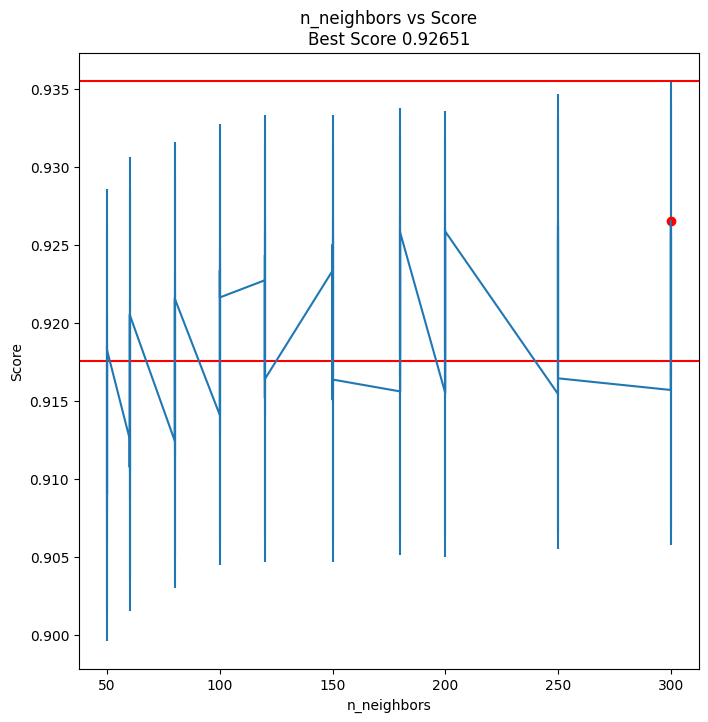

In [17]:
#Knn model

MyKNN = KNeighborsClassifier(algorithm = 'auto')

##Specify grid values for CV

grid_values = {'n_neighbors':[50, 60, 80, 100, 120, 150, 180, 200, 250, 300], 'weights':['uniform','distance'], 'metric':['minkowski','manhattan']}

#Grid Search
from sklearn.model_selection import GridSearchCV

grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', n_jobs = -1, cv = 10)

#Fit the model
grid_knn_acc.fit(X_train, y_train)

# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [18]:
#AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
insample_y_pred_auc = grid_knn_acc.predict_proba(X_train)

#Compute roc_auc for in sample values
print('Roc_auc Score : ' + str(roc_auc_score(y_train,insample_y_pred_auc[:,1])))
print(roc_auc_score(y_train,insample_y_pred_auc[:,1]))

Roc_auc Score : 1.0
1.0


In [19]:
#compute prediction using the model

y_hat_test = grid_knn_acc.predict_proba(X_test) 
print(y_hat_test)

[[1.         0.        ]
 [0.87950253 0.12049747]
 [0.97790691 0.02209309]
 ...
 [0.98019355 0.01980645]
 [0.99384373 0.00615627]
 [0.99656202 0.00343798]]


### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [20]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test[:,1]})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)